In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [97]:
df = pd.read_csv('~/Desktop/googleflu.csv')
print(df.shape)
df.head()

(159, 621)


,Date,9/28/2003,10/5/2003,10/12/2003,10/19/2003,10/26/2003,11/2/2003,11/9/2003,11/16/2003,11/23/2003,...,6/7/2015,6/14/2015,6/21/2015,6/28/2015,7/5/2015,7/12/2015,7/19/2015,7/26/2015,8/2/2015,8/9/2015
0,United States,902.0,952.0,1092.0,1209.0,1249.0,1374.0,1702.0,2148.0,2968.0,...,1150,786,820,1073,1024,770,767,666,735,671
1,Alabama,477.0,501.0,492.0,533.0,594.0,715.0,840.0,1064.0,1458.0,...,910,735,651,707,589,549,486,470,565,682
2,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,910,873,828,780,755,685,678,688,664,718
3,Arizona,606.0,663.0,700.0,819.0,959.0,1167.0,1655.0,2662.0,4935.0,...,1423,720,637,1113,1582,1065,953,1041,963,1031
4,Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1289,1371,1616,1547,1449,1256,1267,1129,1104,1106


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Columns: 621 entries, Date to 8/9/2015
dtypes: float64(218), int64(402), object(1)
memory usage: 771.5+ KB


In [99]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 9/28/2003 to 8/9/2015


In [100]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(weeks = pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [101]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [102]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2003-09-28 00:00:00 - 2015-01-25 00:00:00
Train prediction: 2015-01-26 00:00:00 - 2015-05-03 00:00:00 

Val encoding: 2004-01-04 00:00:00 - 2015-05-03 00:00:00
Val prediction: 2015-05-04 00:00:00 - 2015-08-09 00:00:00

Encoding interval: 4138
Prediction interval: 98


In [103]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array))
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array))
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [104]:
import tensorflow as tf
Model = tf.keras.models.Model
Input = tf.keras.Input

#from keras.models import Model
#from keras.layers import Input, LSTM, Dense
#from keras.optimizers import Adam

latent_dim = 10 # LSTM hidden units
dropout = .01 

# Define an input series and encode it with an LSTM. 
encoder_inputs = tf.keras.layers.Input(shape=(None, 1)) 
encoder = tf.keras.layers.LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = tf.keras.layers.Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = tf.keras.layers.LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = tf.keras.layers.Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [105]:
first_n_samples = 40
batch_size = 8
epochs = 20

encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [106]:
encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((40, 592, 1), (40, 14, 1), (40, 14, 1))

In [107]:
model.compile(tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Train on 32 samples, validate on 8 samples
Epoch 1/20
32/32 [==============================] - 3s 102ms/sample - loss: 0.5682 - val_loss: 0.6621
Epoch 2/20
32/32 [==============================] - 1s 23ms/sample - loss: 0.5148 - val_loss: 0.6239
Epoch 3/20
32/32 [==============================] - 1s 25ms/sample - loss: 0.4699 - val_loss: 0.5919
Epoch 4/20
32/32 [==============================] - 1s 24ms/sample - loss: 0.4293 - val_loss: 0.5654
Epoch 5/20
32/32 [==============================] - 1s 24ms/sample - loss: 0.3993 - val_loss: 0.5457
Epoch 6/20
32/32 [==============================] - 1s 25ms/sample - loss: 0.3722 - val_loss: 0.5298
Epoch 7/20
32/32 [==============================] - 1s 23ms/sample - loss: 0.3559 - val_loss: 0.5169
Epoch 8/20
32/32 [==============================] - 1s 23ms/sample - loss: 0.3388 - val_loss: 0.5048
Epoch 9/20
32/32 [==============================] - 1s 22ms/sample - loss: 0.3275 - val_loss: 0.4919
Epoch 10/20
32/32 [============================

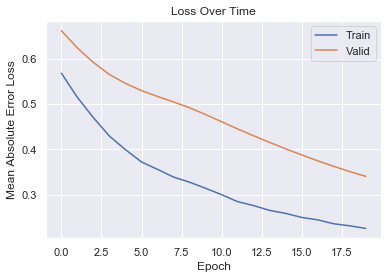

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [109]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [110]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [111]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],
                                         target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    print(pred_series.shape)
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1), encode_series_tail)
    plt.plot(range(x_encode, x_encode+pred_steps),
             target_series, color='orange')
    plt.plot(range(x_encode, x_encode+pred_steps), 
             pred_series, color='teal', linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [112]:
  target_series = decoder_target_data[60,:,:1].reshape(-1,1) 

In [113]:
target_series

array([[-0.15115119],
       [ 0.29759397],
       [-0.305549  ],
       [-0.43169302],
       [ 0.17862708],
       [-1.33482246],
       [-1.09677837],
       [ 0.14777213],
       [-0.95304159],
       [-1.15573453],
       [-1.05382125],
       [-1.10252001],
       [-1.0760033 ],
       [-0.67116144]])

In [114]:
encoder_input_data.shape

(159, 592, 1)

In [115]:
decoder_target_data.shape

(159, 14, 1)

(14, 1)


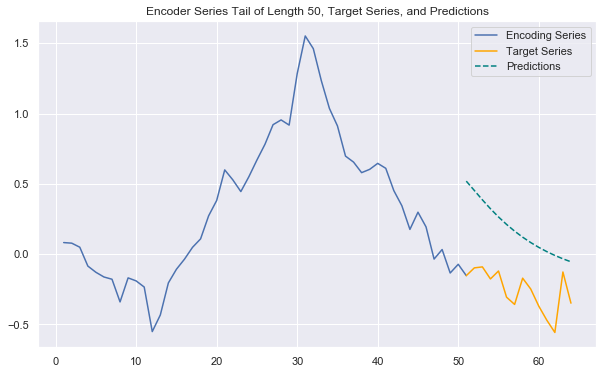

In [116]:
predict_and_plot(encoder_input_data, decoder_target_data, 10) 